In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from src.data import get_data
from src.util import common

from src.features.build_features import series_to_supervised

import pickle

In [170]:
df = pd.read_csv(common.get_project_path() + '/data/raw/data.csv', index_col=0)
df.timestamp = pd.to_datetime(df.timestamp)
df.drop('time', axis=1, inplace=True)
df.head()

,volumeto,volumefrom,open,high,close,low,timestamp
0,783.59,7.51,119.64,119.64,97.38,97.38,2013-06-25 07:00:00
1,710.43,7.72,119.55,119.55,83.90,83.90,2013-06-25 08:00:00
2,0.00,0.00,83.90,83.90,83.90,83.90,2013-06-25 09:00:00
3,0.00,0.00,83.90,83.90,83.90,83.90,2013-06-25 10:00:00
4,411.21,4.90,120.46,120.46,83.92,83.92,2013-06-25 11:00:00


In [171]:
MAS = [3, 6, 12,24,48]
for MA in MAS:
    df['vt_ma' + str(MA)] = df.volumeto.rolling(MA).mean()
    df['vf_ma' + str(MA)] = df.volumefrom.rolling(MA).mean()
#     df['close_ma' + str(MA)] = df.volumeto.rolling(MA).mean()

In [172]:
# df['hour'] = df.timestamp.dt.hour
# df['dom'] = df.timestamp.dt.day
# df['dow'] = df.timestamp.dt.dayofweek
df.drop('timestamp', axis=1, inplace=True)
df.drop(['volumefrom', 'volumeto'], axis=1, inplace=True)

In [173]:
START_INDEX = 36000
N_FEATURES = len(df.columns)

Tx = 96
Ty = 1

In [174]:

sample = df.iloc[START_INDEX:,:]
sample.head()
# fig, ax = plt.subplots(3, sharex=True)
# ax[0].plot(sample.close)
# ax[1].plot(sample.vf_ma24)
# ax[2].plot(sample.vt_ma24)

,open,high,close,low,vt_ma3,vf_ma3,vt_ma6,vf_ma6,vt_ma12,vf_ma12,vt_ma24,vf_ma24,vt_ma48,vf_ma48
36000,2732.34,2735.30,2733.77,2727.56,3.861254e+06,1415.653333,4.487454e+06,1647.153333,6.668891e+06,2463.938333,8.724656e+06,3211.894583,1.120429e+07,4093.522083
36001,2733.77,2736.52,2732.59,2729.17,3.706838e+06,1357.913333,3.933041e+06,1443.163333,6.482514e+06,2395.617500,8.632283e+06,3178.697917,1.106120e+07,4045.678750
36002,2732.59,2741.33,2739.10,2731.35,4.268725e+06,1560.963333,4.309264e+06,1578.658333,6.290659e+06,2323.860000,8.631106e+06,3178.080833,1.079894e+07,3954.887500
36003,2739.10,2742.76,2741.48,2734.53,5.307833e+06,1937.736667,4.584544e+06,1676.695000,5.953087e+06,2195.011667,8.698870e+06,3202.302500,1.041638e+07,3816.458542
36004,2741.48,2766.51,2765.99,2741.48,8.407903e+06,3055.693333,6.057371e+06,2206.803333,5.723750e+06,2096.560000,8.986774e+06,3305.839583,1.032930e+07,3783.663958


In [175]:
X = series_to_supervised(data=sample, n_in=Tx, n_out=Ty)

Y = series_to_supervised(data=list(sample['close']), n_in=Tx, n_out=Ty)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.05, shuffle=False)

Y_test_cache = Y_test
Y_train = Y_train.iloc[:,-Ty:]
Y_test = Y_test.iloc[:,-Ty:]
X_train = X_train.iloc[:,:-(Ty*N_FEATURES)]
X_test = X_test.iloc[:,:-(Ty*N_FEATURES)]


In [176]:
from xgboost import XGBRegressor

In [177]:
parameters = {'nthread':[4], #when use hyperthread, xgboost may become slower
              'objective':['reg:linear'],
              'learning_rate': [.07], #so called `eta` value
              'max_depth': [10],
              'min_child_weight': [4],
              'silent': [1],
              'subsample': [0.7],
              'colsample_bytree': [0.7],
              'n_estimators': [128]}



In [178]:
from sklearn.model_selection import GridSearchCV

In [179]:
xgb_grid = GridSearchCV(XGBRegressor(),
                        parameters,
                        scoring='neg_mean_absolute_error',
                        cv = 2,
                        n_jobs = 5,
                        verbose=True,
                        )



In [180]:
xgb_grid.fit(X_train, Y_train)


Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=5)]: Done   2 out of   2 | elapsed:  1.1min remaining:    0.0s
[Parallel(n_jobs=5)]: Done   2 out of   2 | elapsed:  1.1min finished


GridSearchCV(cv=2, error_score='raise',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid=True, n_jobs=5,
       param_grid={'learning_rate': [0.07], 'min_child_weight': [4], 'subsample': [0.7], 'colsample_bytree': [0.7], 'nthread': [4], 'n_estimators': [128], 'max_depth': [10], 'silent': [1], 'objective': ['reg:linear']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_absolute_error', verbose=True)

In [184]:
print(xgb_grid.best_score_)
print(xgb_grid.best_params_)
from sklearn.metrics import mean_absolute_error, mean_squared_error
mean_squared_error(xgb_grid.predict(X_test), Y_test)

-803.1285820156459
{'learning_rate': 0.07, 'min_child_weight': 4, 'subsample': 0.7, 'colsample_bytree': 0.7, 'nthread': 4, 'n_estimators': 128, 'max_depth': 10, 'silent': 1, 'objective': 'reg:linear'}


3221.5451234885977

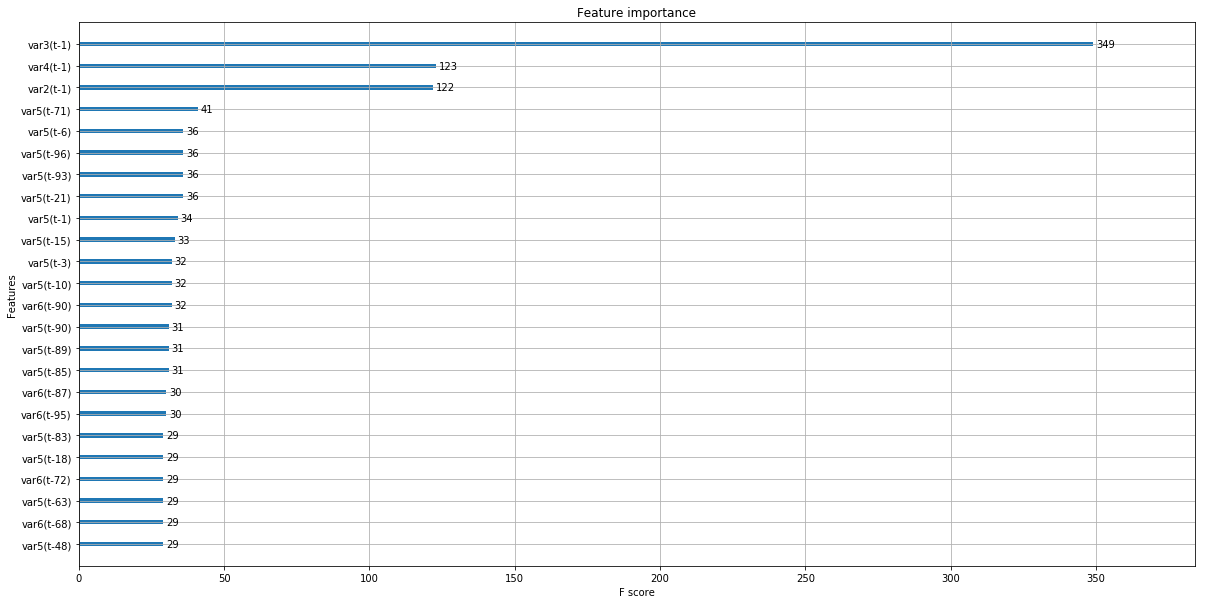

In [182]:
from xgboost import plot_importance

fig, ax = plt.subplots(figsize=(20, 10))
plot_importance(ax=ax, booster=xgb_grid.best_estimator_, max_num_features=24)


In [121]:
results = xgb_grid.cv_results_
results['']

/Users/daniel_stevenson/anaconda3/envs/go-mint-datasci-challenge/lib/python3.5/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/daniel_stevenson/anaconda3/envs/go-mint-datasci-challenge/lib/python3.5/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/daniel_stevenson/anaconda3/envs/go-mint-datasci-challenge/lib/python3.5/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need tr

{'mean_fit_time': array([126.98380697, 126.83511293, 120.4733355 , 136.67961693,
        133.37119496, 130.96109498, 154.73567247, 134.64872658,
         98.35317099]),
 'mean_score_time': array([1.15532005, 1.13173258, 1.22292054, 0.93512857, 1.18368804,
        0.93925858, 0.8296665 , 0.73329198, 0.30075598]),
 'mean_test_score': array([-828.57363989, -820.81669319, -813.76507467, -826.69541323,
        -820.37155717, -810.08631551, -815.63932384, -822.25625186,
        -808.87110593]),
 'mean_train_score': array([-34.34349148, -34.96412012, -35.52799731, -29.20657614,
        -29.69732215, -30.53845568, -23.84378666, -25.1151626 ,
        -26.3059538 ]),
 'param_colsample_bytree': masked_array(data=[0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7],
              mask=[False, False, False, False, False, False, False, False,
                    False],
        fill_value='?',
             dtype=object),
 'param_learning_rate': masked_array(data=[0.07, 0.07, 0.07, 0.07, 0.07, 0.07, 0.07, 0

In [98]:
from sklearn.metrics import roc_auc_score

xgbr = XGBRegressor(**xgb_grid.best_params_)
scorestrain=[]
scorescv=[]
iterations=[]


for i in range(500,len(X_train),500) :                
    print(i)
    xgbr.fit(X_train[:i], Y_train[:i], early_stopping_rounds=50, eval_metric="mae",
    eval_set=[(X_test, Y_test)])
    scorestrain.append(mean_absolute_error(Y_train[:i], xgbr.predict(X_train[:i], ntree_limit=xgbr.best_iteration)))
    scorescv.append(mean_absolute_error(Y_test,xgbr.predict(X_test,ntree_limit=xgbr.best_iteration)))
    iterations.append(i)
  
"""

    print(pd.Series(X_testpred[:,1]).describe())


submission = pd.DataFrame({"ID":test.index, "TARGET":y_pred[:,1]})
submission.to_csv("submission.csv", index=False)


"""



500
[0]	validation_0-mae:6052.93
Will train until validation_0-mae hasn't improved in 50 rounds.
[1]	validation_0-mae:5783.06
[2]	validation_0-mae:5533.29
[3]	validation_0-mae:5298.69
[4]	validation_0-mae:5080.09
[5]	validation_0-mae:4878.49
[6]	validation_0-mae:4689.28
[7]	validation_0-mae:4514.96
[8]	validation_0-mae:4350.61
[9]	validation_0-mae:4200.15
[10]	validation_0-mae:4057.76
[11]	validation_0-mae:3917
[12]	validation_0-mae:3792.86
[13]	validation_0-mae:3671.66
[14]	validation_0-mae:3564.42
[15]	validation_0-mae:3462.12
[16]	validation_0-mae:3366.36
[17]	validation_0-mae:3272.9
[18]	validation_0-mae:3185.92
[19]	validation_0-mae:3107.78
[20]	validation_0-mae:3035.61
[21]	validation_0-mae:2966.91
[22]	validation_0-mae:2900.42
[23]	validation_0-mae:2838.87
[24]	validation_0-mae:2781.47
[25]	validation_0-mae:2728.96
[26]	validation_0-mae:2679.1
[27]	validation_0-mae:2631.86
[28]	validation_0-mae:2590.52
[29]	validation_0-mae:2551.4
[30]	validation_0-mae:2513.29
[31]	validation_0-

[11]	validation_0-mae:3721.82
[12]	validation_0-mae:3582.58
[13]	validation_0-mae:3455.5
[14]	validation_0-mae:3333.78
[15]	validation_0-mae:3221.95
[16]	validation_0-mae:3115.5
[17]	validation_0-mae:3014.31
[18]	validation_0-mae:2921.29
[19]	validation_0-mae:2834.1
[20]	validation_0-mae:2748.54
[21]	validation_0-mae:2669.07
[22]	validation_0-mae:2603.03
[23]	validation_0-mae:2537.24
[24]	validation_0-mae:2472.06
[25]	validation_0-mae:2416.1
[26]	validation_0-mae:2363.7
[27]	validation_0-mae:2309.4
[28]	validation_0-mae:2259.81
[29]	validation_0-mae:2211.11
[30]	validation_0-mae:2167.72
[31]	validation_0-mae:2126.29
[32]	validation_0-mae:2090.42
[33]	validation_0-mae:2059.58
[34]	validation_0-mae:2025.4
[35]	validation_0-mae:1999.54
[36]	validation_0-mae:1968.97
[37]	validation_0-mae:1940.27
[38]	validation_0-mae:1912.01
[39]	validation_0-mae:1892.34
[40]	validation_0-mae:1866.13
[41]	validation_0-mae:1849.37
[42]	validation_0-mae:1834.14
[43]	validation_0-mae:1827.7
[44]	validation_0-

[24]	validation_0-mae:1049.06
[25]	validation_0-mae:973.576
[26]	validation_0-mae:904.588
[27]	validation_0-mae:840.249
[28]	validation_0-mae:780.196
[29]	validation_0-mae:725.01
[30]	validation_0-mae:675.594
[31]	validation_0-mae:627.195
[32]	validation_0-mae:582.518
[33]	validation_0-mae:540.863
[34]	validation_0-mae:502.854
[35]	validation_0-mae:462.674
[36]	validation_0-mae:430.013
[37]	validation_0-mae:399.257
[38]	validation_0-mae:371.457
[39]	validation_0-mae:343.115
[40]	validation_0-mae:316.699
[41]	validation_0-mae:291.709
[42]	validation_0-mae:268.885
[43]	validation_0-mae:249.357
[44]	validation_0-mae:230.074
[45]	validation_0-mae:212.931
[46]	validation_0-mae:195.289
[47]	validation_0-mae:178.996
[48]	validation_0-mae:165.162
[49]	validation_0-mae:152.081
[50]	validation_0-mae:139.138
[51]	validation_0-mae:128.781
[52]	validation_0-mae:117.44
[53]	validation_0-mae:108.931
[54]	validation_0-mae:101.003
[55]	validation_0-mae:93.3319
[56]	validation_0-mae:87.8026
[57]	validat

[37]	validation_0-mae:400.682
[38]	validation_0-mae:370.463
[39]	validation_0-mae:343.787
[40]	validation_0-mae:318.482
[41]	validation_0-mae:293.208
[42]	validation_0-mae:270.693
[43]	validation_0-mae:250.598
[44]	validation_0-mae:232.241
[45]	validation_0-mae:217.058
[46]	validation_0-mae:201.098
[47]	validation_0-mae:186.137
[48]	validation_0-mae:172.543
[49]	validation_0-mae:158.685
[50]	validation_0-mae:148.215
[51]	validation_0-mae:136.144
[52]	validation_0-mae:123.451
[53]	validation_0-mae:113.975
[54]	validation_0-mae:105.636
[55]	validation_0-mae:96.6145
[56]	validation_0-mae:89.2435
[57]	validation_0-mae:82.4079
[58]	validation_0-mae:76.931
[59]	validation_0-mae:71.7188
[60]	validation_0-mae:66.1728
[61]	validation_0-mae:60.747
[62]	validation_0-mae:56.6268
[63]	validation_0-mae:53.5926
[64]	validation_0-mae:50.7183
[65]	validation_0-mae:48.9119
[66]	validation_0-mae:46.765
[67]	validation_0-mae:45.0993
[68]	validation_0-mae:44.1297
[69]	validation_0-mae:43.2044
[70]	validati

[50]	validation_0-mae:139.301
[51]	validation_0-mae:128.41
[52]	validation_0-mae:118.09
[53]	validation_0-mae:106.722
[54]	validation_0-mae:97.4559
[55]	validation_0-mae:89.3601
[56]	validation_0-mae:79.7278
[57]	validation_0-mae:73.4843
[58]	validation_0-mae:68.4462
[59]	validation_0-mae:62.6559
[60]	validation_0-mae:58.636
[61]	validation_0-mae:53.9234
[62]	validation_0-mae:51.4005
[63]	validation_0-mae:48.7276
[64]	validation_0-mae:46.1464
[65]	validation_0-mae:43.9622
[66]	validation_0-mae:42.1214
[67]	validation_0-mae:40.7349
[68]	validation_0-mae:39.7044
[69]	validation_0-mae:38.7867
[70]	validation_0-mae:38.3607
[71]	validation_0-mae:38.0975
[72]	validation_0-mae:37.983
[73]	validation_0-mae:38.0144
[74]	validation_0-mae:38.0901
[75]	validation_0-mae:38.2939
[76]	validation_0-mae:38.4469
[77]	validation_0-mae:38.6495
[78]	validation_0-mae:38.8308
[79]	validation_0-mae:39.0239
[80]	validation_0-mae:39.2197
[81]	validation_0-mae:39.6433
[82]	validation_0-mae:39.8421
[83]	validatio

[66]	validation_0-mae:50.6967
[67]	validation_0-mae:48.8693
[68]	validation_0-mae:47.2011
[69]	validation_0-mae:45.5354
[70]	validation_0-mae:44.6713
[71]	validation_0-mae:43.8328
[72]	validation_0-mae:43.2417
[73]	validation_0-mae:43.0655
[74]	validation_0-mae:42.5832
[75]	validation_0-mae:42.279
[76]	validation_0-mae:42.0103
[77]	validation_0-mae:41.8782
[78]	validation_0-mae:41.9941
[79]	validation_0-mae:41.9164
[80]	validation_0-mae:41.8396
[81]	validation_0-mae:41.8203
[82]	validation_0-mae:41.8167
[83]	validation_0-mae:41.8305
[84]	validation_0-mae:41.8615
[85]	validation_0-mae:41.9046
[86]	validation_0-mae:41.9544
[87]	validation_0-mae:42.0374
[88]	validation_0-mae:42.1138
[89]	validation_0-mae:42.188
[90]	validation_0-mae:42.2511
[91]	validation_0-mae:42.3409
[92]	validation_0-mae:42.4227
[93]	validation_0-mae:42.504
[94]	validation_0-mae:42.5578
[95]	validation_0-mae:42.6577
[96]	validation_0-mae:42.7503
[97]	validation_0-mae:42.7785
[98]	validation_0-mae:42.8156
[99]	validati

[85]	validation_0-mae:59.1336
[86]	validation_0-mae:59.5834
[87]	validation_0-mae:59.8636
[88]	validation_0-mae:60.264
[89]	validation_0-mae:60.5236
[90]	validation_0-mae:60.7982
[91]	validation_0-mae:61.1115
[92]	validation_0-mae:61.2702
[93]	validation_0-mae:61.4711
[94]	validation_0-mae:61.6924
[95]	validation_0-mae:61.8944
[96]	validation_0-mae:62.1054
[97]	validation_0-mae:62.2879
[98]	validation_0-mae:62.4295
[99]	validation_0-mae:62.5731
[100]	validation_0-mae:62.7628
[101]	validation_0-mae:62.8685
[102]	validation_0-mae:63.0348
[103]	validation_0-mae:63.2
[104]	validation_0-mae:63.3423
[105]	validation_0-mae:63.5065
[106]	validation_0-mae:63.5638
[107]	validation_0-mae:63.6536
[108]	validation_0-mae:63.741
[109]	validation_0-mae:63.8029
[110]	validation_0-mae:63.9175
[111]	validation_0-mae:63.9329
[112]	validation_0-mae:63.9811
[113]	validation_0-mae:64.0335
[114]	validation_0-mae:64.1046
[115]	validation_0-mae:64.1276
[116]	validation_0-mae:64.0377
[117]	validation_0-mae:63.99

[115]	validation_0-mae:37.3663
[116]	validation_0-mae:37.3943
[117]	validation_0-mae:37.4259
[118]	validation_0-mae:37.4722
[119]	validation_0-mae:37.4756
[120]	validation_0-mae:37.4434
[121]	validation_0-mae:37.4643
[122]	validation_0-mae:37.4768
[123]	validation_0-mae:37.4803
[124]	validation_0-mae:37.4677
[125]	validation_0-mae:37.5454
[126]	validation_0-mae:37.5526
[127]	validation_0-mae:37.5613


'\n\n    print(pd.Series(X_testpred[:,1]).describe())\n\n\nsubmission = pd.DataFrame({"ID":test.index, "TARGET":y_pred[:,1]})\nsubmission.to_csv("submission.csv", index=False)\n\n\n'

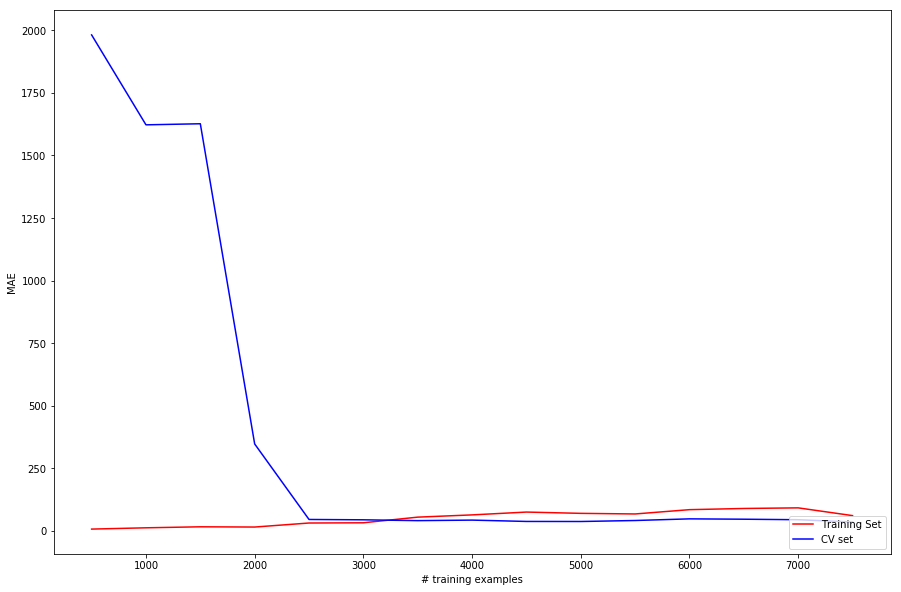

In [99]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,10))
plt.plot(iterations,scorestrain,'r')
plt.plot(iterations,scorescv, 'b')
# plt.ylim(0.8,0.9)
# plt.xlim(1000,55000)
plt.xlabel('# training examples')
plt.ylabel('MAE')
plt.legend(['Training Set','CV set'],loc='lower right')